In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from string import punctuation
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')
!wget https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle -P /tmp
plt.style.use("/tmp/rose-pine-dawn.mplstyle")

--2023-11-20 08:43:47--  https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40905 (40K) [text/plain]
Saving to: ‘/tmp/rose-pine-dawn.mplstyle’

rose-pine-dawn.mpls 100%[===================>]  39.95K  --.-KB/s    in 0.01s   

2023-11-20 08:43:47 (2.77 MB/s) - ‘/tmp/rose-pine-dawn.mplstyle’ saved [40905/40905]



In [3]:
data = pd.read_csv('/content/drive/MyDrive/IS/password strength tester/data.csv', on_bad_lines='skip')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669640 entries, 0 to 669639
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  669639 non-null  object
 1   strength  669640 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 10.2+ MB


In [ ]:
data.shape

(669640, 2)

In [ ]:
data.isna().sum()

password    1
strength    0
dtype: int64

In [4]:
data.dropna(inplace=True)

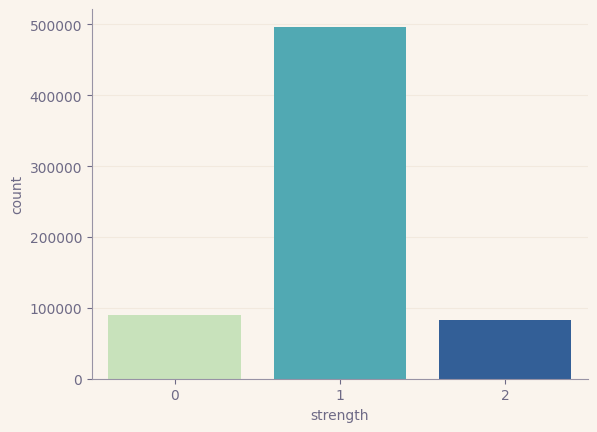




Number of weak passwords: 89701 (13.4%)
Number of medium passwords: 496801 (74.19%)
Number of strong passwords: 83137 (12.42%)


In [ ]:
sns.countplot(x=data['strength'], palette='YlGnBu')
plt.show();


medium, weak, strong = data['strength'].value_counts()
print('\n\n')
print(f'Number of weak passwords: {weak} ({np.round(weak / len(data) * 100,2)}%)')
print(f'Number of medium passwords: {medium} ({np.round(medium / len(data) * 100,2)}%)')
print(f'Number of strong passwords: {strong} ({np.round(strong / len(data) * 100,2)}%)')

#**Data Analysis and Feature Extraction**

In [5]:
# Count number of characters
data['length'] = data['password'].apply(lambda x: len(x))

# Check if number is in the string
data['has_num'] = data['password'].apply(lambda x: any(char.isdigit() for char in x))

# Count numbers
data['num_cnt'] = data['password'].apply(lambda x: sum(c.isdigit() for c in x))

# Check for lower case
data['has_lower'] = data['password'].apply(lambda x: any(char.islower() for char in x))

# Count lower case
data['lower_cnt'] = data['password'].apply(lambda x: sum(c.islower() for c in x))

# Check for upper case
data['has_upper'] = data['password'].apply(lambda x: any(char.isupper() for char in x))

# Count upper case
data['upper_cnt'] = data['password'].apply(lambda x: sum(c.isupper() for c in x))

# Check for special
data['has_special'] = data['password'].apply(lambda x: any(char in punctuation for char in x))

# Count specials
data['special_cnt'] = data['password'].apply(lambda x: sum(char in punctuation for char in x))

data.head()

,password,strength,length,has_num,num_cnt,has_lower,lower_cnt,has_upper,upper_cnt,has_special,special_cnt
0,kzde5577,1,8,True,4,True,4,False,0,False,0
1,kino3434,1,8,True,4,True,4,False,0,False,0
2,visi7k1yr,1,9,True,2,True,7,False,0,False,0
3,megzy123,1,8,True,3,True,5,False,0,False,0
4,lamborghin1,1,11,True,1,True,10,False,0,False,0


In [ ]:
data.tail(200)

,password,strength,length,has_num,num_cnt,has_lower,lower_cnt,has_upper,upper_cnt,has_special,special_cnt
669440,17758494-0,1,10,True,9,False,0,False,0,True,1
669441,123951357z,1,10,True,9,True,1,False,0,False,0
669442,allende123,1,10,True,3,True,7,False,0,False,0
669443,4rnVPfTA4MwCNv8y,2,16,True,3,True,6,True,7,False,0
669444,nagi6305,1,8,True,4,True,4,False,0,False,0
...,...,...,...,...,...,...,...,...,...,...,...
669635,10redtux10,1,10,True,4,True,6,False,0,False,0
669636,infrared1,1,9,True,1,True,8,False,0,False,0
669637,184520socram,1,12,True,6,True,6,False,0,False,0
669638,marken22a,1,9,True,2,True,7,False,0,False,0


In [6]:
# Get all columns which are numerical
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()

# Convert target to categorical
data['strength'] = data['strength'].astype('category')

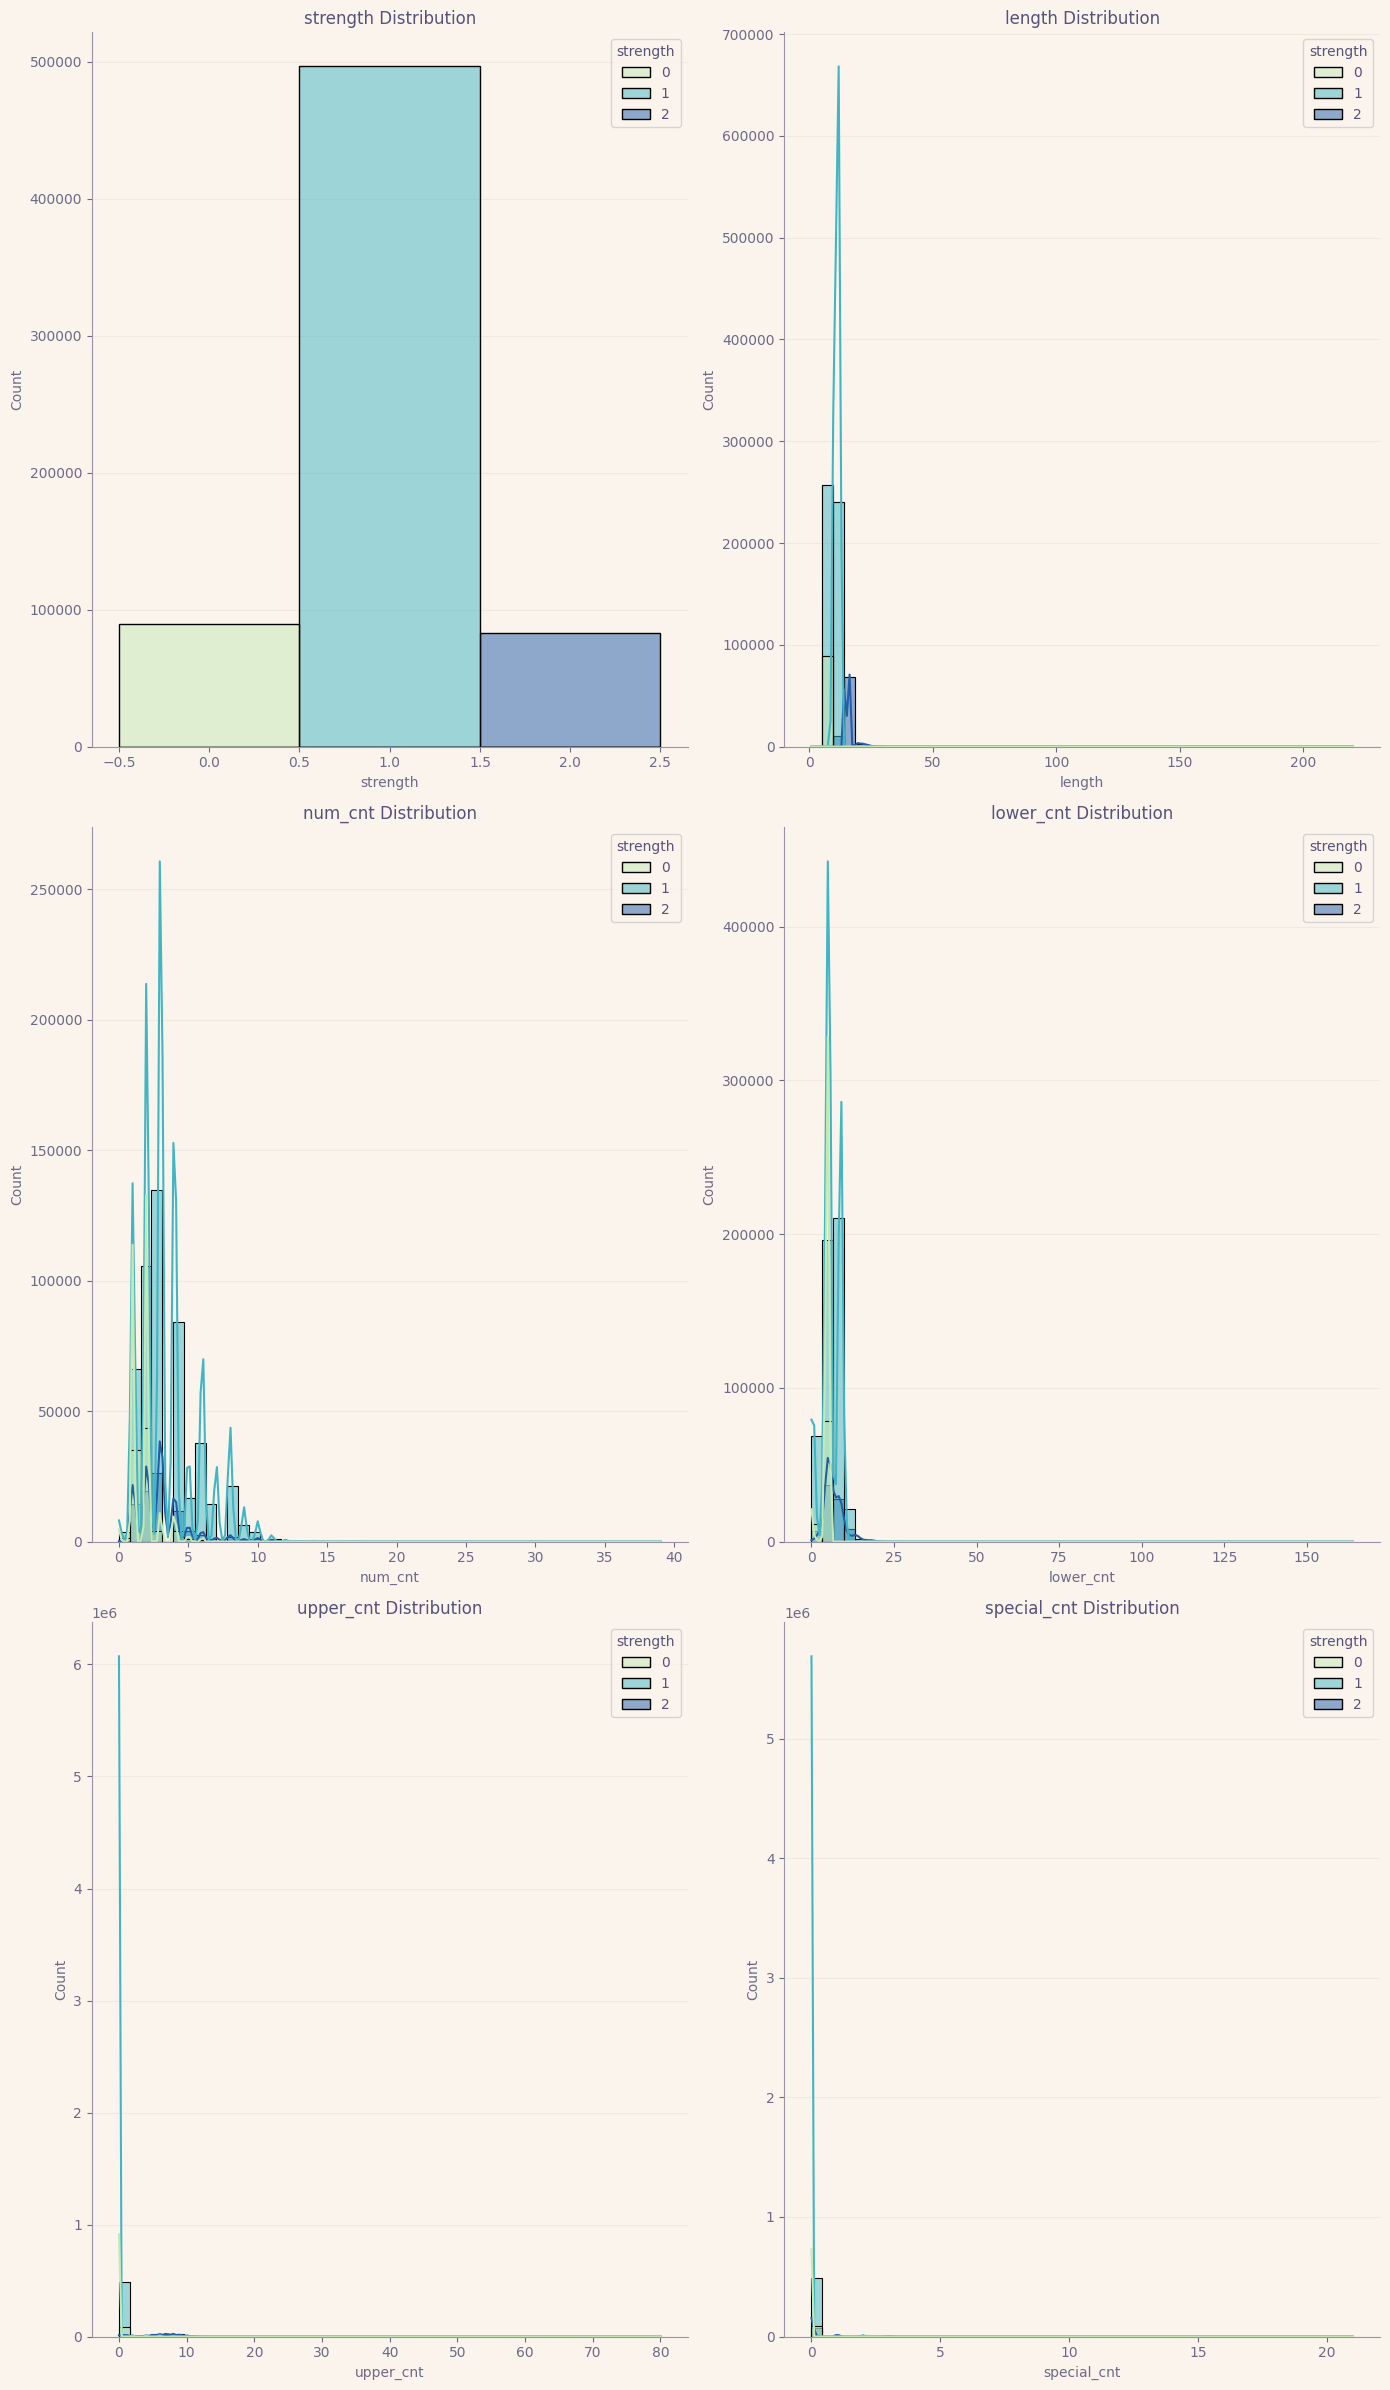

In [ ]:
plt.figure(figsize=(14, len(numerical_columns)*4))
for idx, column in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns)//2 + len(numerical_columns)%2, 2, idx+1)
    sns.histplot(x=column, hue="strength", data=data, bins=50, kde=True, palette='YlGnBu')
    plt.title(f"{column} Distribution")
    plt.tight_layout()

plt.show();

# **Password Classifier**

In [14]:
data.to_csv('/content/drive/MyDrive/IS/password strength tester/newdata.csv', index=False)

In [7]:
X = data.drop(columns=['password', 'strength'])
y = data['strength'].astype(int)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1702)

In [9]:
params = {'objective':'multiclass',
          'num_classes': 3,
          'n_estimators':100,
          'max_depth': 10,
          'learning_rate': 0.05,
          'num_leaves': 70,
          'reg_alpha': 3,
          'reg_lambda': 3,
          'subsample': 0.7,
          'colsample_bytree': 0.7}
          # 'verbose': -1}

In [10]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [11]:
model = lgb.train(params,
                 num_boost_round=300,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                #  verbose_eval=False,
                #  early_stopping_rounds=50
                 )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 535711, number of used features: 9
[LightGBM] [Info] Start training from score -2.011955
[LightGBM] [Info] Start training from score -0.298337
[LightGBM] [Info] Start training from score -2.085686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [13]:
model_filename = 'pwdmodel.txt'
drive_directory = '/content/drive/MyDrive/IS/'
model_filepath = drive_directory + model_filename
model.save_model(model_filepath)

In [ ]:
y_pred = model.predict(X_test)
y_pred = [np.argmax(p) for p in y_pred]

In [ ]:
accuracy_score(y_test, y_pred)

1.0

# **Evaluating the model**

**Input Dataframe 1**

In [ ]:
lst = ['chameleon', 'RedSox', 'sandbags', 'bunnyhop!', 'IntenseCrabtree', 'password1', 'deer2000', 'john1234',
       'p@ssw0rd', 'l33th4x0r', 'g0ldf1sh', 'crabcrab', 'stopstop', 'treetree', 'passpass', 'qwerty', '123456', 'asdfgh','911',
       '314159', '27182', '112', 'jsmith123', '1/1/1970', '555–1234', 'New York', 'Texas', 'China', 'London', 'Apple', 'Microsoft', 'GameOfThrones']
evaldf = pd.DataFrame({'password':lst})

In [ ]:
# Count number of characters
evaldf['length'] = evaldf['password'].apply(lambda x: len(x))

# Check if number is ievaldfn the string
evaldf['has_num'] = evaldf['password'].apply(lambda x: any(char.isdigit() for char in x))

# Count numbers
evaldf['num_cnt'] = evaldf['password'].apply(lambda x: sum(c.isdigit() for c in x))

# Check for lower case
evaldf['has_lower'] = evaldf['password'].apply(lambda x: any(char.islower() for char in x))

# Count lower case
evaldf['lower_cnt'] = evaldf['password'].apply(lambda x: sum(c.islower() for c in x))

# Check for upper case
evaldf['has_upper'] = evaldf['password'].apply(lambda x: any(char.isupper() for char in x))

# Count upper case
evaldf['upper_cnt'] = evaldf['password'].apply(lambda x: sum(c.isupper() for c in x))

# Check for special
evaldf['has_special'] = evaldf['password'].apply(lambda x: any(char in punctuation for char in x))

# Count specials
evaldf['special_cnt'] = evaldf['password'].apply(lambda x: sum(char in punctuation for char in x))

In [ ]:
evaldf.head()

,password,length,has_num,num_cnt,has_lower,lower_cnt,has_upper,upper_cnt,has_special,special_cnt
0,chameleon,9,False,0,True,9,False,0,False,0
1,RedSox,6,False,0,True,4,True,2,False,0
2,sandbags,8,False,0,True,8,False,0,False,0
3,bunnyhop!,9,False,0,True,8,False,0,True,1
4,IntenseCrabtree,15,False,0,True,13,True,2,False,0


In [ ]:
evaldf.drop(columns=['password'], inplace=True)
eval_preds = model.predict(evaldf)

In [ ]:
eval_preds = [np.argmax(p) for p in eval_preds]

In [ ]:
tmpdf = pd.DataFrame({'password': lst, 'strength': eval_preds})
tmpdf

,password,strength
0,chameleon,1
1,RedSox,0
2,sandbags,1
3,bunnyhop!,1
4,IntenseCrabtree,2
5,password1,1
6,deer2000,1
7,john1234,1
8,p@ssw0rd,1
9,l33th4x0r,1


**Input Dataframe 2**

In [ ]:
strongs = ['fzNq&k4F', 'D44d8F^x', '6GyojA#Lt', 'q%tL8E2Yb', '3kx$boZSE@', '8haVag&Con', 'Xhk%2tEQ5dy', 'KW!f58z47CQE', 'yVG^npaP%48g',
          'D#ey9bam52vHQg%iB7Bpav24WDQ3qz', 'nLFEA@MeMYd5BTwG3gNr3hGn3FJ8Bu*H9gfS']
strongdf = pd.DataFrame({'password':strongs})

In [ ]:
# Count number of characters
strongdf['length'] = strongdf['password'].apply(lambda x: len(x))

# Check if number is in the string
strongdf['has_num'] = strongdf['password'].apply(lambda x: any(char.isdigit() for char in x))

# Count numbers
strongdf['num_cnt'] = strongdf['password'].apply(lambda x: sum(c.isdigit() for c in x))

# Check for lower case
strongdf['has_lower'] = strongdf['password'].apply(lambda x: any(char.islower() for char in x))

# Count lower case
strongdf['lower_cnt'] = strongdf['password'].apply(lambda x: sum(c.islower() for c in x))

# Check for upper case
strongdf['has_upper'] = strongdf['password'].apply(lambda x: any(char.isupper() for char in x))

# Count upper case
strongdf['upper_cnt'] = strongdf['password'].apply(lambda x: sum(c.isupper() for c in x))

# Check for special
strongdf['has_special'] = strongdf['password'].apply(lambda x: any(char in punctuation for char in x))

# Count specials
strongdf['special_cnt'] = strongdf['password'].apply(lambda x: sum(char in punctuation for char in x))

In [ ]:
strongdf.head()

,password,length,has_num,num_cnt,has_lower,lower_cnt,has_upper,upper_cnt,has_special,special_cnt
0,fzNq&k4F,8,True,1,True,4,True,2,True,1
1,D44d8F^x,8,True,3,True,2,True,2,True,1
2,6GyojA#Lt,9,True,1,True,4,True,3,True,1
3,q%tL8E2Yb,9,True,2,True,3,True,3,True,1
4,3kx$boZSE@,10,True,1,True,4,True,3,True,2


In [ ]:
strongdf.drop(columns=['password'], inplace=True)
strong_preds = model.predict(strongdf)
strong_preds = [np.argmax(p) for p in strong_preds]

In [ ]:
tmpdf2 = pd.DataFrame({'password': strongs, 'strength': strong_preds})
tmpdf2

,password,strength
0,fzNq&k4F,1
1,D44d8F^x,1
2,6GyojA#Lt,1
3,q%tL8E2Yb,1
4,3kx$boZSE@,1
5,8haVag&Con,1
6,Xhk%2tEQ5dy,1
7,KW!f58z47CQE,1
8,yVG^npaP%48g,1
9,D#ey9bam52vHQg%iB7Bpav24WDQ3qz,2
